# Area Under What Curve?

When training a classifier, there are lots of ways to assess how "good" it is. One of the metrics most commonly reported is the area under the receiver-operator characteristic curve, known as the AUC, or AUROC, or ROC AUC...

Thinking about this recently, I refreshed my memory on why it is a useful and important quantity for evaluating a model, and I was also struck by how badly it's named. This notebook documents my ponderings.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

# Binary Classification

In a binary classification problem, we are interested in determining which of two classes each example belongs to, based on other known quantities which characterise the example.

Call the label $y \in \{ 0, 1 \}$ and the features $x \in \mathcal{X}$, drawn from some data distribution $\pi(x, y) = \pi_{x|y}(x|y) \pi_y(y)$.

We will have a model which provides a function which takes a feature vector and produces a score $s \in \mathbb{R}$:

$$
s = m(x)
$$

Using this, we will make a classification decision based on whether or not the score exceeds some threshold $t \in \mathbb{R}$:

$$
z(s, t) = \begin{cases} 1 & s \geq t \\ 0 & s < t \end{cases}
$$

For each example to which we apply our model there are four possible outcomes, where the true label $y$ and estimated label $z$ may be each be $0$ or $1$.

The operation of classifier depends on three factors:
* The prevalence of the two classes, i.e. $\pi_y(y)$.
* How good the model is at separating the two classes in feature space
* Where we set the threshold

The important thing when calculating metrics to evaluate our classiier is that we clearly distinguish which of these factors we're trying to assess.

In [71]:
def draw_pos_samples(num=1):
    return stats.t.rvs(3, loc=1.0, scale=1.0, size=num)

def draw_neg_samples(num=1):
    return stats.t.rvs(3, loc=-1.0, scale=1.0, size=num)

def generate_some_data(num_pos=1000, num_neg=1000):
    x_pos = generate_pos_samples(num=num_pos)
    x_neg = generate_neg_samples(num=num_neg)
    x = np.concatenate((x_pos, x_neg))
    y = np.concatenate((np.ones(num_pos, dtype=bool), np.zeros(num_neg, dtype=bool)))
    return x, y

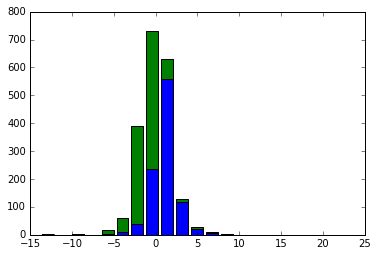

In [72]:
x, y = generate_some_data()
fig, ax = plt.subplots()
ax.hist((x[y], x[~y]), bins=20, stacked=True)
plt.show()

# Pairwise Ordering Probability

Suppose the thing we want to characterise is the model's ability to separate the two classes. To do this, we need some measure of performance which does not depend on the class distribution or the threshold we set.

* The need to be independent of the threshold means that we can only look at scores, not the final outcomes of the classifier. 
* The need to be independent of the class distribution means that whatever measure we come up with must be suitably conditioned on class. We could not, for example, use anything based on classifying a randomly chosen data point.

There is a convenient measure which satisfies these two properties. Suppose we take a random example from each class, and attempt to classify them together. Since we know we have exactly one example from each class, the only thing that matters is the score ordering. We'll infer that the example with the larger score is in class $1$ and the other one is in class $0$. The probability that we're correct is:

$$
p(\hat{s} > \check{s} \;|\; \hat{y}=1, \check{y}=0)
$$

Where $\hat{\cdot}$ and $\check{\cdot}$ denote variables associated with each of the two examples.

Why don't we call this POP, for pairwise ordering probability?

How to estimate POP? Well, we can get to it very easily with a Monte Carlo estimate.

\begin{align}
p(\hat{s} > \check{s} \;|\; \hat{y}=1, \check{y}=0) &= p(m(\hat{x}) > m(\check{x}) \;|\; \hat{y}=1, \check{y}=0) \\
&= \int p(m(\hat{x}) > m(\check{x}), \hat{x}, \check{x} \;|\; \hat{y}=1, \check{y}=0) d\hat{x} d\check{x} \\
&= \int p(m(\hat{x}) > m(\check{x}) \;|\; \hat{x}, \check{x}) p(\hat{x} \;|\; \hat{y}=0) p(\check{x} \;|\; \check{y}=0) d\hat{x} d\check{x} \\
&= \int \mathbb{1}(m(\hat{x}) > m(\check{x})) p(\hat{x} \;|\; \hat{y}=0) p(\check{x} \;|\; \check{y}=0) d\hat{x} d\check{x} \\
&\leftarrow \frac{1}{N} \sum_n \mathbb{1}(m(\hat{x}_n) > m(\check{x}_n))
\end{align}

Where $\hat{x}_n$ and $\check{x}_n$ are samples drawn respectively from $\pi_{x|y}(\cdot|y=1)$ and $\pi_{x|y}(\cdot|y=0)$. So we can just randomly draw pairs of samples from our data, one from each class, and count how often the score for the $1$-class example is larger.

In [73]:
def sample_estimate_pop(N=1000):
    num_right = 0
    num_wrong = 0
    for i in range(N):
        pos_sample = draw_pos_samples()
        neg_sample = draw_neg_samples()
        if (pos_sample > neg_sample):
            num_right += 1
        else:
            num_wrong += 1
    return num_right / (num_right + num_wrong)

In [74]:
print(sample_estimate_pop())

0.86


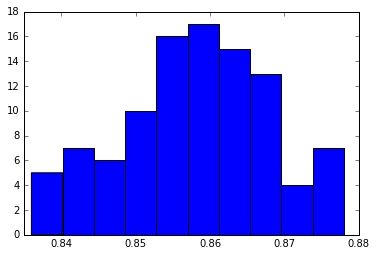

In [75]:
sample_estimate_arr = np.array([sample_estimate_pop() for k in range(100)])
fig, ax = plt.subplots()
ax.hist(sample_estimate_arr, bins=10)
plt.show()

# Should We Be Talking About FPRs And All That?

There's another way. Denote the probability densities of the score conditional on the classes as $f_0$ and $f_1$. We can massage the POP like this (glossing over the formalities of measures and the like):

\begin{align}
p(\hat{s} > \check{s} \;|\; \hat{y}=1, \check{y}=0) &= \int p(\hat{s} > \check{s}, \check{s}=t \;|\; \hat{y}=1, \check{y}=0) \; dt \\
&= \int p(\hat{s} > t, \check{s}=t \;|\; \hat{y}=1, \check{y}=0) \; dt \\
&= \int p(\hat{s} > t \;|\; \hat{y}=1) \; p(\check{s}=t \;|\; \check{y}=0) \; dt \\
&= \int p(\hat{s} > t \;|\; \hat{y}=1) \; f_0(t) \; dt
\end{align}

Now at last we'll introduce some familiar functions:

\begin{align}
\rho(t) &= p(z=1|y=1) = p(s>t|y=1) \\
\sigma(t) &= p(z=0|y=0) = p(s<t|y=0) \\
\end{align}

$\rho$ is recall or sensitivity or true positive probability. $\sigma$ is the complement of specificity or true negative probability.

The true negative probability is just the CDF of the $0$-class score distribution:

$$
p(s<t|y=0) = \int_{-\infty}^{t} f_0(u) du
$$

Inverting this using the fundamental law of calculus, we have:

$$
f_0(t) = \frac{d\sigma}{dt}
$$

We can plug this into our expression for pop, do a change of variables $v=\sigma(t)$, and voila:

\begin{align}
p(\hat{s} > \check{s} \;|\; \hat{y}=1, \check{y}=0) &= \int p(\hat{s} > t \;|\; \hat{y}=1) \; f_0(t) \; dt \\
&= \int \rho(t) \; \frac{d\sigma}{dt} \; dt \\
&= \int \rho(\sigma^{-1}(v)) \; dv
\end{align}

If we were to plot $\rho$ against $\sigma$, this would be the area under the curve.

But this, of course, was all in terms of the underlying model probabilities, which we don't have. We need to estimate this using data somehow.

We can estimate $\rho$ and $\sigma$ using a Monte Carlo estimate:

\begin{align}
\rho(t) &= p(s>t|y=1) \leftarrow \frac{1}{\hat{N}} \sum_n \mathbb{1}(\hat{s}_{n} > t) \\
\sigma(t) &= p(s<t|y=0) \leftarrow \frac{1}{\check{N}} \sum_n \mathbb{1}(\check{s}_{n} < t)
\end{align}

Where $\{\hat{s}_{n}\}$ and $\{\check{s}_{n}\}$ are samples from the $1$- and $0$-class respectively, and $\hat{N}$ and $\check{N}$ are the number of samples from each class.

With $N = \hat{N}+\check{N}$ data points, the domain of $t$ is divided up into $N+1$ intervals, each defining a $\rho,\sigma$ pair. We can plot these.

In [92]:
def tpr_tnr_from_data(x, y):
    idx = np.argsort(x)
    x_sort = x[idx]
    y_sort = y[idx]

    num_pos = np.sum(y)
    num_neg = np.sum(~y)
    num_pos_above = num_pos
    num_neg_below = 0
    tpr = np.zeros((len(x_sort) + 1))
    tnr = np.zeros((len(x_sort) + 1))

    for k, s in enumerate(x_sort):
        if y_sort[k]:
            num_pos_above -= 1
        else:
            num_neg_below += 1
        tpr[k + 1] = float(num_pos_above) / float(num_pos)
        tnr[k + 1] = float(num_neg_below) / float(num_neg)
    
    return tpr, tnr

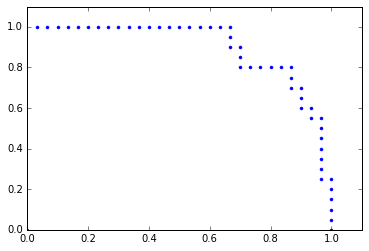

In [101]:
x_small, y_small = generate_some_data(num_pos=20, num_neg=30)
tpr, tnr = tpr_tnr_from_data(x_small, y_small)
fig, ax = plt.subplots()
ax.plot(tnr, tpr, '.')
ax.set_xlim([0.0, 1.1])
ax.set_ylim([0.0, 1.1])
plt.show()

So... if we know that POP is equal to the area under the $\rho-\sigma$ curve, then we could approximate it by joining the dots and then integrating under the resulting shape.

We can make this a bit more formal by going back to the expecation we had back at the start of this section, using the approximation for $\rho$, and then using a sample approximation for the expectation. Something like this:

\begin{align}
p(\hat{s} > \check{s} \;|\; \hat{y}=1, \check{y}=0) &= \int \rho(t) \; f_0(t) \; dt \\
&\approx \int \left[ \frac{1}{\hat{N}} \sum_n \mathbb{1}(\hat{s}_{n} > t) \right] \; f_0(t) \; dt \\
&\approx \frac{1}{\check{N}} \sum_k \left[ \frac{1}{\hat{N}} \sum_n \mathbb{1}(\hat{s}_{n} > \check{s}_k) \right] \\
&\approx \frac{1}{\check{N} \hat{N}} \sum_{nk} \mathbb{1}(\hat{s}_{n} > \check{s}_k)
\end{align}

This simply says that we can divide the unit square into $\hat{N} \times \check{N}$ little rectangles, each corresponding to a pair of data points with one from each class. Then we can count the pairs where the $0$-class sample has a lower score than the $1$-class sample and divide by the total. Neat.

# Ranting About Terminology

There is so much terminology for different metrics and tests for classifiers, which exists because these models have been studied in such a large number of different fields over the course of the last century. This obscures the relatively simple ideas and needlessly complicates learning. It is high time we stopped talking about Receiver-Operator Characteristics. None of us are using these for radar or telegraph systems these days. And it is high time we stopped naming a key metric after the method of approximation rather than the underlying quantity it actually estimates. We must rename AUC to POP.

# References